# Quick-and-dirty experimental image viewer

In [1]:
#%matplotlib inline
import numpy as np
from pathlib import Path
import os
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure
from PIL import Image

dictBands = {'b': (0,2), 'g': (1,1), 'r': (2,0)}

/home/lisa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lisa/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility
  return f(*args, **kwds)


In [2]:
plt.rcParams["figure.figsize"] = (20,12)

In [3]:
DATADIR = "/home/lisa/Schreibtisch/Projekt/roadDetection/data/"
RAW_IMAGES = DATADIR + "sat_images/3093"      #'../data/raw/images'

In [4]:
def transform2visible(inds, bands):
    imgArr = inds.read(masked=True)
    msk = inds.read_masks()
    sz = np.shape(imgArr)
    visArray = np.zeros((sz[1], sz[2], 4), 'uint8')   
    
    visArray[..., 3] = msk[0]
    
    for k in bands:
        planetScopeIndex, RGBIndex  = dictBands[k]
        # Normalize each band-image
        ima = (imgArr[planetScopeIndex][:,:])
        img = (ima.astype('float')/ima.max())

        # Adaptive Equalization
        img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)
        masked_img_adapteq = np.ma.masked_array(img_adapteq, np.logical_not(msk[0]))
        np.ma.set_fill_value(masked_img_adapteq, 0)
        visArray[..., RGBIndex] = masked_img_adapteq.filled()*256
    return visArray

In [5]:
def write_visible(src, meta):    
    outpath = RAW_IMAGES + '/' + file.name.rsplit('AnalyticMS.tif')[0]+'newVisual.tif'
    with rio.open(outpath, 'w', **meta) as outds:
        sz = np.shape(src)
        output  = np.zeros((4, sz[0], sz[1]), 'uint8')  
        for i in range(4):
            output[i] = src[..., i]        
        outds.write(output.astype(np.uint8))

In [8]:
def make_visible(file):
    with rio.open(file) as inds:
        meta = inds.meta.copy() 
        meta['dtype'] = 'uint8'
        nodata=0
        
        rgbImage = transform2visible(inds, ['b', 'g', 'r'])
        plt.imshow(rgbImage)
        plt.show()   
        write_visible(rgbImage, meta)
        

/home/lisa/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


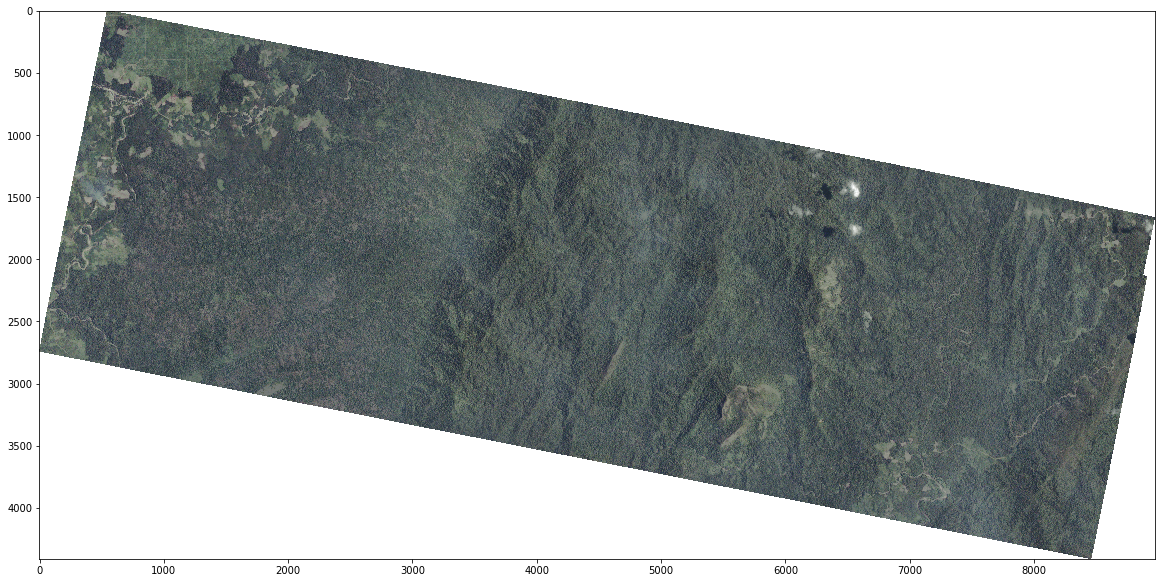

[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 ...

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  ...
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]


In [ ]:
for file in Path(RAW_IMAGES).iterdir():
    if file.name.endswith(('AnalyticMS.tif', 'AnalyticMS.tiff')):
        make_visible(file)

In [ ]:
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf




def plot_histograms(img, img_adapteq):
    # Display results
    f, axes = plt.subplots(2,2, figsize=(8, 4))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 1])
    ax_img.set_title('Adaptive equalization')

    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    plt.subplots_adjust(wspace=0.4)